<a href="https://colab.research.google.com/github/tristanpadiou/Travel-assistant/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install langchain_google_genai
! pip install langchain-community
! pip install langgraph
! pip install pyowm
! pip install wikipedia
! pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 951.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=dcb7100f3ac089928a90593af5d19016f334a3b7a5aa89462dd51ca88b2cb01b
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.schema import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
)

from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

from typing_extensions import TypedDict
from typing import Annotated
import pytz
from datetime import datetime
import os
import requests
import json
import gradio as gr


In [3]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
pse=userdata.get('programmable_search_engine')
OPENWEATHERMAP_API_KEY=userdata.get('open_weather_key')
os.environ['OPENWEATHERMAP_API_KEY']=OPENWEATHERMAP_API_KEY

In [4]:
GEMINI_MODEL='gemini-1.5-flash'

In [5]:
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [6]:
# trip data

schedule = {
    "Jeudi 26 Décembre": [
        {"time": "09:00", "event": "Petit Déjeuner"},
        {"time": "10:00", "event": "Atelier de Tissage", "details": "1 personne"},
        {"time": "16:00", "event": "Visite guidée de la Koutoubia"},
        {"time": "19:00", "event": "Vol EJU4665 Paris", "details": "2 personnes /Couple Sekfali"},
        {"time": "20:30", "event": "Dîner au riad", "details": "12 ou 13 personnes"},
    ],
    "Vendredi 27 Décembre": [
        {"time": "09:00", "event": "Petit Déjeuner"},
        {"time": "10:20", "event": "Vol LX2200 Genève", "details": "1 personne William Burgat"},
        {"time": "10:00", "event": "Visite Guidée des Tombeaux Saadiens"},
        {"time": "15:00", "event": "Visite aux Jardins de Majorelle et Musée YSL"},
        {"time": "19:00", "event": "Transfert pour aller au restaurant AZAR"},
        {"time": "19:30", "event": "Dîner au restaurant AZAR"},
    ],
    "Samedi 28 Décembre": [
        {"time": "08:00", "event": "Petit Déjeuner"},
        {"time": "09:00", "event": "Randonnée dans l'Atlas"},
        {"time": "19:30", "event": "Dîner au Riad", "details": "11 personnes"},
        {"time": "21:00", "event": "Soirée KARAOKE"},
    ],
    "Dimanche 29 Décembre": [
        {"time": "09:00", "event": "Petit Déjeuner"},
        {"time": "09:30", "event": "Arrivée de Lili-Chambre Jade"},
        {"time": "14:30", "event": "Excursion en Quads", "details": "(2 heures)"},
        {"time": "Dîner", "event": "Dîner au Scarabeo Camp"},
    ],
    "Lundi 30 Décembre": [
        {"time": "07:00", "event": "Petit Déjeuner"},
        {"time": "08:00", "event": "Excursion à Ouarzazate"},
        {"time": "20:00", "event": "Dîner au Riad", "details": "12 personnes"},
    ],
    "Mardi 31 Décembre": [
        {"time": "09:00", "event": "Petit Déjeuner"},
        {"time": "10:00", "event": "Visite Guidée à la Merdersa Ben Youssef"},
        {"time": "14:00", "event": "HAMAM et MASSAGE x 2 à vérifier"},
        {"time": "15:30", "event": "HAMAM et MASSAGE x 2 à vérifier"},
        {"time": "17:00", "event": "HAMAM et MASSAGE x 2 à vérifier"},
        {"time": "17:00", "event": "Coiffeuse et vernis"},
        {"time": "20:00", "event": "Réveillon au Riad avec DJ"},
    ],
    "Mercredi 1er Janvier": [
        {"time": "12:00", "event": "HAMAM et MASSAGE à vérifier"},
        {"time": "13:30", "event": "HAMAM et MASSAGE à vérifier"},
        {"time": "15:00", "event": "HAMAM et MASSAGE à vérifier"},
        {"time": "16:15", "event": "Excursion en Sidecar", "details": "(1h30)"},
        {"time": "19:30", "event": "Dîner au Restaurant Dar Yacout"},
    ],
    "Jeudi 2 Janvier": [
        {"time": "11:00", "event": "Atelier de cuisine"},
        {"time": "14:00", "event": "Déjeuner à la terrasse"},
        {"time": "16:30", "event": "Départ Sekfali x 2"},
        {"time": "Programme à définir", "event": "Programme à définir"},
    ],
    "Vendredi Janvier": [
        {"time": "08:00", "event": "Départ famille Padiou x 8"},
        {"time": "09:00", "event": "Départ Rossignol x 2"},
    ],
}



In [7]:

# location
loc='Marrakech'
hotel='le clos des arts'


# initializing time and date tool

#creating a schema
class time_tool_schema(BaseModel):
  continent: str = Field(description='continent')
  city: str = Field(description='city')

def date_time_tool(continent: str,city: str) -> str:
  """
  tool to get the current date and time in a city.

  """
  city=city.replace(' ','_')
  query=continent+'/'+city
  timezone = pytz.timezone(query)
  # Get the current time in UTC, and then convert it to the Marrakech timezone
  utc_now = datetime.now(pytz.utc)  # Get current time in UTC
  localized_time = utc_now.astimezone(timezone)  # Convert to Marrakech time
  time=localized_time.strftime('%Y-%m-%d %H:%M:%S')
  return time

current_date_time_tool=StructuredTool.from_function(name='current_date_time_tool', func=date_time_tool, description='To get the current date and time in any city',args_schema=time_tool_schema, return_direct=True)


In [8]:
def google_image_search(query: str) -> str:
  """Search for images using Google Custom Search API
  args: query
  return: image url
  """
  # Define the API endpoint for Google Custom Search
  url = "https://www.googleapis.com/customsearch/v1"

  params = {
      "q": query,
      "cx": pse,
      "key": GOOGLE_API_KEY,
      "searchType": "image",  # Search for images
      "num": 1  # Number of results to fetch
  }

  # Make the request to the Google Custom Search API
  response = requests.get(url, params=params)
  data = response.json()

  # Check if the response contains image results
  if 'items' in data:
      # Extract the first image result
      image_url = data['items'][0]['link']
      return image_url
  else:
      return "Sorry, no images were found for your query."

google_image_tool=Tool(name='google_image_tool', func=google_image_search, description='Use this tool to search for images using Google Custom Search API')

In [33]:
def schedule_tool():
  """
  Use this tool to pull the schedule from the database, you do not need more info'
  args:none



  """
  return schedule
get_schedule=Tool(name='get_schedule',func=schedule_tool, description='Use this tool to pull the schedule from the database, you do not need more info')

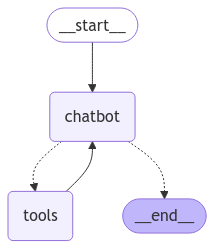

In [40]:
# langgraph
#loading tools
api_tools=load_tools(['openweathermap-api','wikipedia'])
langgraph_tools=[current_date_time_tool,google_image_tool,get_schedule]+api_tools


# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(langgraph_tools)

def chatbot(state: State):
  f"""You are a travel assistant that answers user questions about their trip.
  you have access to the following tools:
  {langgraph_tools}.
  Depending on the request, leverage which tools to use if necessary."""
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=langgraph_tools)
graph_builder.add_node("tools", tool_node)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph = graph_builder.compile()



display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [41]:
def travel_agent(query,history):
  history_langchain_format = []
  for msg in history:
      if msg['role'] == "user":
          history_langchain_format.append(HumanMessage(content=msg['content']))
      elif msg['role'] == "assistant":
          history_langchain_format.append(AIMessage(content=msg['content']))
  history_langchain_format.append(HumanMessage(content=query))
  return graph.invoke({'messages':history_langchain_format})['messages'][-1].content

In [42]:
interface=gr.ChatInterface(
    travel_agent,
    type='messages'
)
interface.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c59d38382b602518ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c59d38382b602518ef.gradio.live


In [13]:
print(f"Gradio instance URL: {url[2]}")

NameError: name 'url' is not defined